### 1. Summary of the Dataset

In [38]:
import pandas as pd
df = pd.read_csv('../../../../Analysis/Summary/FreeViewing/Data/FreeViewing_Summary_25sec.csv')

print(df.describe())

        Attention      NumFix   AvgFixDur    NumBlink  AvgBlinkDur  \
count  576.000000  576.000000  576.000000  576.000000   576.000000   
mean     0.545139   42.881944   26.563273   11.453125    16.303206   
std      0.498391   11.096413    9.381985    6.900376    18.076721   
min      0.000000   11.000000    8.272727    0.000000     0.000000   
25%      0.000000   36.000000   20.369371    6.000000     8.500000   
50%      1.000000   43.000000   25.258058   11.000000    11.428571   
75%      1.000000   51.000000   31.000000   16.000000    16.722222   
max      1.000000   71.000000   78.555556   36.000000   184.166667   

        AvgPupDia   VarPupDia  OffStimFram  
count  576.000000  576.000000   576.000000  
mean     3.652201    0.163817    15.475694  
std      0.623364    0.129883    25.108518  
min      2.206459    0.014131     0.000000  
25%      3.197595    0.078554     3.000000  
50%      3.620357    0.120445     8.000000  
75%      4.110508    0.204088    17.000000  
max      

### 2. Identify the best window size using the random forest model

In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Load CSV files into DataFrames
window_sizes = [5, 10, 15, 20, 25]
dataframes = [pd.read_csv(f"../../../../Analysis/Summary/FreeViewing/Data/FreeViewing_Summary_{w}sec.csv") for w in window_sizes]

# Loop through each DataFrame
results = []
for w, df in zip(window_sizes, dataframes):
    # Extract features and labels
    X = df[['NumFix', 'AvgFixDur', 'NumBlink', 'AvgBlinkDur', 'AvgPupDia', 'VarPupDia', 'OffStimFram']]
    y = df['Attention']
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize and train classifier
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)
    
    # Evaluate using cross-validation
    scores = cross_val_score(clf, X, y, cv=5)
    
    # Make predictions and evaluate performance
    y_pred = clf.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Store results
    results.append({'window': w, 'cv_mean_score': scores.mean(), 'classification_report': report})

# Compare results to find the best window size
best_result = max(results, key=lambda x: x['cv_mean_score'])
print(f"Best window size: {best_result['window']} with mean CV score: {best_result['cv_mean_score']:.2f}")
print(best_result['classification_report'])


Best window size: 25 with mean CV score: 0.57
{'0': {'precision': 0.6274509803921569, 'recall': 0.6153846153846154, 'f1-score': 0.6213592233009708, 'support': 52.0}, '1': {'precision': 0.6923076923076923, 'recall': 0.703125, 'f1-score': 0.6976744186046512, 'support': 64.0}, 'accuracy': 0.6637931034482759, 'macro avg': {'precision': 0.6598793363499246, 'recall': 0.6592548076923077, 'f1-score': 0.6595168209528111, 'support': 116.0}, 'weighted avg': {'precision': 0.6632339938627971, 'recall': 0.6637931034482759, 'f1-score': 0.6634641586409324, 'support': 116.0}}


#### 2.1 Use the Logit Regression model to statistically identify how many features are relevant to the mind wandering

In [40]:
# By default, Jupyter Notebooks and JupyterLab will use your current working directory as the root directory.
# Cur dir: /Analysis/Summary/FreeViewing/Code
import pandas as pd
import statsmodels.api as sm

df = pd.read_csv('../../../../Analysis/Summary/FreeViewing/Data/FreeViewing_Summary_25sec.csv')
df['Attention'] = df['Attention'].astype(int)

# Define the predictor variables (X) and the target variable (y)
X = df[['NumFix', 'AvgFixDur', 'NumBlink', 'AvgBlinkDur', 'AvgPupDia', 'VarPupDia', 'OffStimFram']]
y = df['Attention']

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit a logistic regression model
logit_model = sm.Logit(y, X).fit()

# Summarize the results
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.644299
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              Attention   No. Observations:                  576
Model:                          Logit   Df Residuals:                      568
Method:                           MLE   Df Model:                            7
Date:                Mon, 06 May 2024   Pseudo R-squ.:                 0.06497
Time:                        19:24:34   Log-Likelihood:                -371.12
converged:                       True   LL-Null:                       -396.90
Covariance Type:            nonrobust   LLR p-value:                 7.090e-09
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.1874      1.405     -0.845      0.398      -3.940       1.566
NumFix          0.0350    

**Summary**
- The best window size (25) yielded a mean CV score of 0.57.
- Significant predictors of mind wandering are NumFix, NumBlink, and VarPupDia.
- The logistic regression model's Pseudo R-squ. value (0.06497) is relatively low, suggesting that while these predictors provide some explanation, additional or more accurate features may further improve the model.

**Next Steps**
- Investigate additional predictors or other window sizes.
- Consider cross-validation or other statistical tests to ensure robustness.
- Explore alternative models to compare predictive performance.

#### 2.2 Correlation Heatmap of extracted features

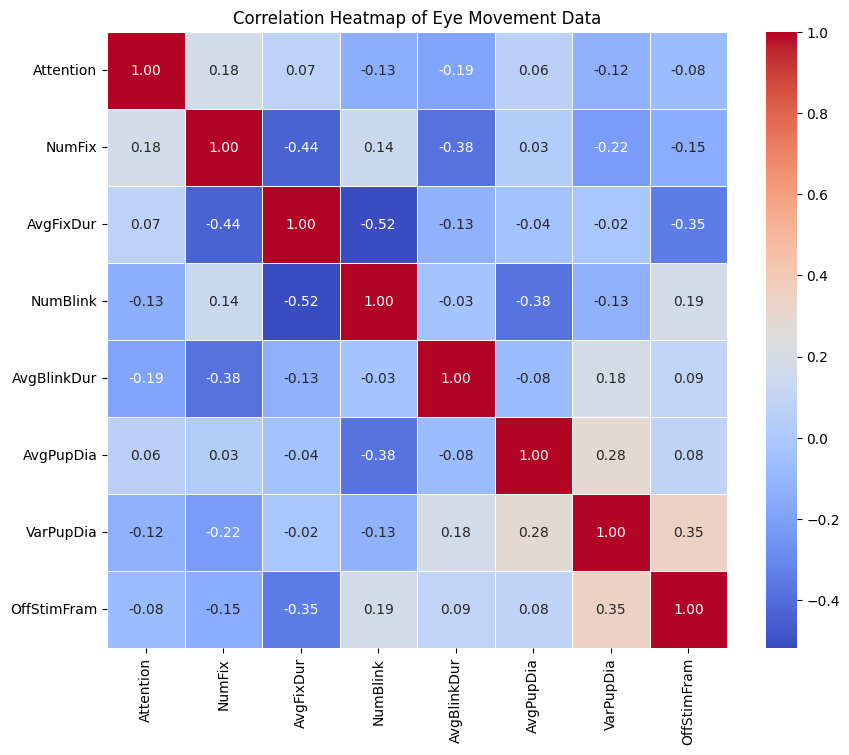

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('../../../../Analysis/Summary/FreeViewing/Data/FreeViewing_Summary_25sec.csv')
X = df[['Attention', 'NumFix', 'AvgFixDur', 'NumBlink', 'AvgBlinkDur', 'AvgPupDia', 'VarPupDia', 'OffStimFram']]
# Compute correlation matrix
corr_matrix = X.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap of Eye Movement Data")
plt.show()